In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score, precision_score, f1_score, classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
# Load Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
columns = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
df = pd.read_csv(url, header=None, names=columns)
df["Diagnosis"] = df["Diagnosis"].map({"M": 1, "B": 0})
df.drop(columns=["ID"], inplace=True)
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

# Split Data (70% Train, 15% Validation, 15% Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [13]:
# Define Models and Hyperparameters
models = {
    "SVM": (SVC(probability=True, class_weight='balanced'), 
            {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}),
    
    "KNN": (KNeighborsClassifier(), 
            {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}),

    "DecisionTree": (DecisionTreeClassifier(class_weight='balanced'), 
                     {'max_depth': [3, 5, 7, 10], 'criterion': ['gini', 'entropy']}),

    "LogisticRegression": (LogisticRegression(class_weight='balanced', max_iter=1000), 
                           {'C': [0.1, 1, 10, 100]})
}

best_model, best_params, best_score = None, None, 0

# Perform Nested Cross-Validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for model_name, (model, param_grid) in models.items():
    # Apply StandardScaler only if needed (SVM, KNN, Logistic Regression)
    steps = []
    if model_name in ["SVM", "KNN", "LogisticRegression"]:
        steps.append(('scaler', StandardScaler()))
    steps.append((model_name.lower(), model))
    
    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(
        pipeline, 
        {f'{model_name.lower()}__' + k: v for k, v in param_grid.items()}, 
        cv=inner_cv, 
        scoring='recall'  # Keep recall as evaluation metric
    )
    
    nested_cv_results = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='recall')  
    mean_score = nested_cv_results.mean()
    
    print(f"{model_name} Nested CV Recall Score: {mean_score:.4f} ± {nested_cv_results.std():.4f}")
    
    if mean_score > best_score:
        best_model, best_score = model_name, mean_score

print(f"Best Model: {best_model}") 

# Perform Final Grid Search for Best Model
final_steps = []
if best_model in ["SVM", "KNN", "LogisticRegression"]:
    final_steps.append(('scaler', StandardScaler())) 
final_steps.append((best_model.lower(), models[best_model][0]))

final_pipeline = Pipeline(final_steps)

final_grid_search = GridSearchCV(
    final_pipeline, 
    {f'{best_model.lower()}__' + k: v for k, v in models[best_model][1].items()}, 
    cv=inner_cv, 
    scoring='recall'  # Keep recall as evaluation metric
)
final_grid_search.fit(X_train, y_train)
final_best_params = final_grid_search.best_params_

print(f"Best Hyperparameters: {final_best_params}")

# Final Model Training and Testing
if best_model in ["SVM", "KNN", "LogisticRegression"]:
    scaler = StandardScaler()
    X_train_val = np.vstack([X_train, X_val])
    scaler.fit(X_train_val)
    X_train_val_scaled = scaler.transform(X_train_val)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_val_scaled = np.vstack([X_train, X_val])  # No scaling for DecisionTree
    X_test_scaled = X_test  # No scaling for DecisionTree

final_model = models[best_model][0].set_params(**{k.split('__')[-1]: v for k, v in final_best_params.items()})
final_model.fit(X_train_val_scaled, np.hstack([y_train, y_val]))
y_test_pred = final_model.predict(X_test_scaled)

test_recall = recall_score(y_test, y_test_pred)  
print(f"Final Test Recall Score: {test_recall:.4f}")

# Print Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_test_pred))


SVM Nested CV Recall Score: 0.9524 ± 0.0175
KNN Nested CV Recall Score: 0.9115 ± 0.0475
DecisionTree Nested CV Recall Score: 0.9317 ± 0.0489
LogisticRegression Nested CV Recall Score: 0.9593 ± 0.0141
Best Model: LogisticRegression
Best Hyperparameters: {'logisticregression__C': 10}
Final Test Recall Score: 0.9062

 Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        53
           1       1.00      0.91      0.95        32

    accuracy                           0.96        85
   macro avg       0.97      0.95      0.96        85
weighted avg       0.97      0.96      0.96        85



/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


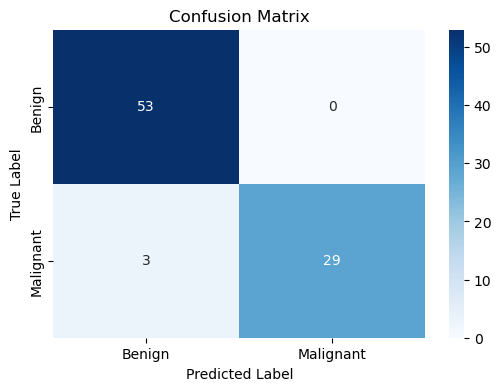

In [15]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

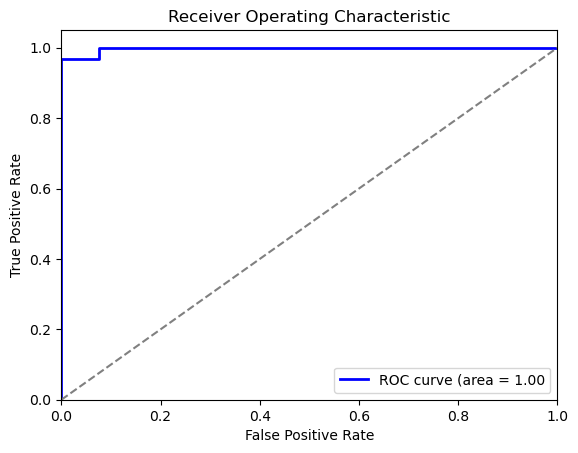

In [17]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

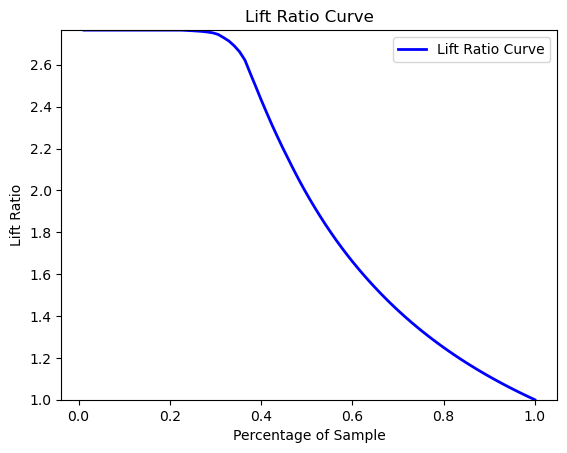

In [19]:
# Lift Ratio Curve 
percentiles = np.linspace(1 / len(y_test), 1, len(y_test))  
sorted_proba = np.sort(y_test_proba)[::-1]
cumulative_gains = np.cumsum(sorted_proba) / np.sum(sorted_proba)
lift_ratio = cumulative_gains / np.where(percentiles == 0, 1e-10, percentiles)

plt.figure()
plt.plot(percentiles, lift_ratio, color='blue', lw=2, label='Lift Ratio Curve')
plt.xlabel('Percentage of Sample')
plt.ylabel('Lift Ratio')
plt.title('Lift Ratio Curve')
plt.legend(loc='upper right')
plt.ylim([1, max(lift_ratio)])  # Ensure valid y-axis limits
plt.show()
